# Compare different energy carriers for the Iron and Steel industry subsector in the Eurostat annual energy balances in terms of how well they align with stel produced by different "routes"

Steel production comes from reading a PDF from World Steel

In [154]:
import tabula
import pandas as pd
import numpy as np

import sys
sys.path.append('../../src/construct/')
import util

In [160]:
def get_prod(url):
    df = tabula.read_pdf(url, pages=6, lattice=True, multiple_tables=True)[2]
    df = (
        df
        .rename(columns=df.loc[0].str.split('\r', expand=True)[0].str.replace('%', '').str.strip()).drop(0)
        .set_index(np.nan)
        .rename_axis(index='country')
        .loc['Austria':'Other Europe', :'Electric']
        .drop(['Turkey', 'Other Europe'])
        .apply(util.to_numeric)
    )
    df = (
        df
        .apply(lambda x: x.mul(df['Million']).div(100))
        .drop('Million', axis=1)
    )

    other_eu = df.loc['European Union (28)'] - df.loc[:'European Union (28)'].drop('European Union (28)').sum()
    df.loc['Others'] += other_eu
    df['Total'] = df.sum(axis=1)
    df.index = df.index.str.replace('\(e\)', '').str.strip()
    
    return df.drop('European Union (28)')

prod_2018 = get_prod('https://www.worldsteel.org/en/dam/jcr:96d7a585-e6b2-4d63-b943-4cd9ab621a91/World%2520Steel%2520in%2520Figures%25202019.pdf')
prod_2015 = get_prod('https://www.worldsteel.org/en/dam/jcr:4f060d8b-3602-4ffe-9e87-7e93e0659449/Word+Steel+in+-Figures+2016.pdf')

In [92]:
energy_balances = pd.read_csv('../../build/annual_energy_balances.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [200]:
all_consumption = energy_balances.xs(['FC_IND_IS_E', 'TOTAL'], level=['cat_code', 'carrier_code']).droplevel(0)  # all consumption of fuels in steel industry
solid_consumption = energy_balances.xs(['FC_IND_IS_E', 'C0000X0350-0370'], level=['cat_code', 'carrier_code']).droplevel(0)  # consumption of solid fuels in steel industry  
bf_consumption = energy_balances.xs(['TI_BF_E', 'C0000X0350-0370'], level=['cat_code', 'carrier_code']).droplevel(0)  # consumption of fuels in blast furnaces (a separate category to the steel industry)
electricity_consumption = energy_balances.xs(['FC_IND_IS_E', 'E7000'], level=['cat_code', 'carrier_code']).droplevel(0)  # consumption of electricity in steel industry  

In [201]:
for yr, prod in {2015: prod_2015, 2018: prod_2018}.items():
    _all = all_consumption.xs(yr, level='year')
    _solid = solid_consumption.xs(yr, level='year')
    _bf = bf_consumption.xs(yr, level='year')
    _electricity = electricity_consumption.xs(yr, level='year')
    for i in prod.index:
        try: 
            prod.loc[i, 'all'] = _all.pop(util.get_alpha2(i))
            prod.loc[i, 'solid'] = _solid.pop(util.get_alpha2(i))
            prod.loc[i, 'bf'] = _bf.pop(util.get_alpha2(i))
            prod.loc[i, 'electricity'] = _electricity.pop(util.get_alpha2(i))
        except LookupError:
            continue
    prod.loc['Others', 'all'] = _all.sum()
    prod.loc['Others', 'solid'] = _solid.sum()
    prod.loc['Others', 'bf'] = _bf.sum()
    prod.loc['Others', 'electricity'] = _electricity.sum()
    prod['all_inc_bf'] = prod['all'] + prod['bf'] - prod['solid']

In [202]:
prod_contrib_2015 = prod_2015.div(prod_2015.sum())
prod_contrib_2018 = prod_2018.div(prod_2018.sum())

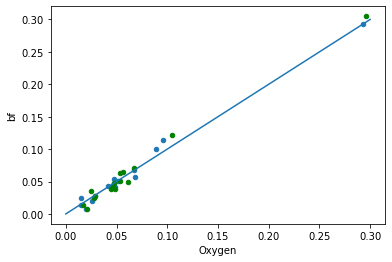

In [184]:
ax = prod_contrib_2015.plot.scatter(x='Oxygen', y='bf')
prod_contrib_2018.plot.scatter(x='Oxygen', y='bf', ax=ax, c='g')
ax.plot([0, 0.3], [0, 0.3])

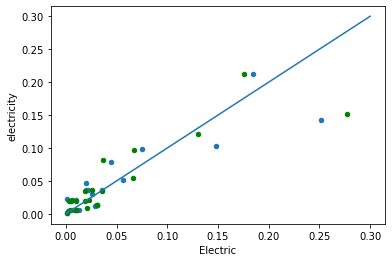

In [185]:
ax = prod_contrib_2015.plot.scatter(x='Electric', y='electricity')
prod_contrib_2018.plot.scatter(x='Electric', y='electricity', ax=ax, c='g')
ax.plot([0, 0.3], [0, 0.3])

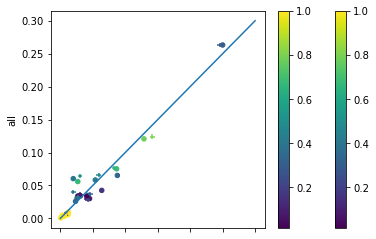

In [190]:
ax = prod_contrib_2015.plot.scatter(x='Total', y='all', c=prod_2015.Electric.div(prod_2015.Total).fillna(0), cmap='viridis')
prod_contrib_2018.plot.scatter(
    x='Total', y='all', ax=ax, marker='+', c=prod_2018.Electric.div(prod_2018.Total).fillna(0), cmap='viridis', legend=False
)
ax.plot([0, 0.3], [0, 0.3])

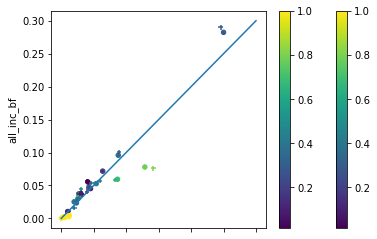

In [203]:
ax = prod_contrib_2015.plot.scatter(x='Total', y='all_inc_bf', c=prod_2015.Electric.div(prod_2015.Total).fillna(0), cmap='viridis')
prod_contrib_2018.plot.scatter(
    x='Total', y='all_inc_bf', ax=ax, marker='+', c=prod_2018.Electric.div(prod_2018.Total).fillna(0), cmap='viridis', legend=False
)
ax.plot([0, 0.3], [0, 0.3])

In [205]:
prod_2018.corr()

,Oxygen,Electric,Total,all,bf,electricity,all_inc_bf,solid
Oxygen,1.000000,0.437582,0.873418,0.876310,0.993650,0.710746,0.981845,0.555446
Electric,0.437582,1.000000,0.826722,0.768124,0.478887,0.877626,0.616321,0.529516
Total,0.873418,0.826722,1.000000,0.974528,0.880942,0.943545,0.947483,0.700572
all,0.876310,0.768124,0.974528,1.000000,0.882172,0.937953,0.954376,0.801772
bf,0.993650,0.478887,0.880942,0.882172,1.000000,0.753561,0.981758,0.621831
electricity,0.710746,0.877626,0.943545,0.937953,0.753561,1.000000,0.854749,0.669209
all_inc_bf,0.981845,0.616321,0.947483,0.954376,0.981758,0.854749,1.000000,0.693329
solid,0.555446,0.529516,0.700572,0.801772,0.621831,0.669209,0.693329,1.000000


In [206]:
prod_2015.corr()

,Oxygen,Electric,Total,all,bf,electricity,all_inc_bf,solid
Oxygen,1.000000,0.458643,0.896542,0.863574,0.993089,0.715238,0.978083,0.654260
Electric,0.458643,1.000000,0.819095,0.786271,0.513231,0.892063,0.650360,0.528362
Total,0.896542,0.819095,1.000000,0.967683,0.909011,0.938169,0.965330,0.736783
all,0.863574,0.786271,0.967683,1.000000,0.874979,0.950191,0.952637,0.841931
bf,0.993089,0.513231,0.909011,0.874979,1.000000,0.770933,0.979775,0.705934
electricity,0.715238,0.892063,0.938169,0.950191,0.770933,1.000000,0.872838,0.726602
all_inc_bf,0.978083,0.650360,0.965330,0.952637,0.979775,0.872838,1.000000,0.763913
solid,0.654260,0.528362,0.736783,0.841931,0.705934,0.726602,0.763913,1.000000
